# Libraries

In [41]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import shutil

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from scipy import ndimage

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import filters

from imgaug import augmenters as iaa

from tqdm import tqdm
from pathlib import Path

import cv2
from sklearn.model_selection import StratifiedKFold
import torch
from torch import nn
from torch import Tensor
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose

import PIL

from datetime import datetime
import json
import gc

import time
t_start = time.time()

# Global variable

In [42]:
TRAIN_IMG_PATH = "../input/tgs-salt-identification-challenge/train/images/"
TEST_IMG_PATH = "../input/tgs-salt-identification-challenge/test/images/"
DEPTH_PATH = "../input/tgs-salt-identification-challenge/depths.csv"
TRAIN_MASK_PATH = "../input/tgs-salt-identification-challenge/train/masks/"
TRAIN_INFO_PATH = "../input/tgs-salt-identification-challenge/train.csv"
FILENAME = "checkpoint.pth.tar"
BEST_FILENAME = "model_best.pth.tar"

# basic parameters
IMG_ORI_SIZE = 101
IMG_TAR_SIZE = 101

# Keras Model parameters
START_NEURONS = 16
DROPOUT_RATIO = 0.5

MODEL1_ADAM_LR = 0.01
MODEL1_EPOCHS = 100
MODEL1_BATCH_SIZE = 64
MODEL1_STEPS_PER_EPOCH_TRAIN = 200
MODEL1_LOSS = 'binary_crossentropy'

MODEL2_ADAM_LR = 0.01
MODEL2_EPOCHS = 100
MODEL2_BATCH_SIZE = 64
MODEL2_STEPS_PER_EPOCH_TRAIN = 200
MODEL2_LOSS = 'lovasz_loss'

# ReduceLROnPlateau parameters
MODEL1_REDUCE_FACTOR = 0.5
MODEL1_REDUCE_PATIENT = 5

MODEL2_REDUCE_FACTOR = 0.5
MODEL2_REDUCE_PATIENT = 5

version = 1

# Name
BASIC_NAME = f'Unet_resnet_v{version}'
SAVE_MODEL_NAME = BASIC_NAME + '.model'
SUBMISSION_NAME = BASIC_NAME + '.csv'

In [58]:
# encoding=utf8
import cv2
import numpy as np
from torch import nn
from functools import reduce

################################################################################
# related functions & loss functions
################################################################################


def upsample(img):
    if IMG_ORI_SIZE == IMG_TAR_SIZE:
        return img
    return cv2.resize(img, (IMG_TAR_SIZE, IMG_TAR_SIZE))


def downsample(img):
    if IMG_ORI_SIZE == IMG_TAR_SIZE:
        return img
    return cv2.resize(img, (IMG_ORI_SIZE, IMG_ORI_SIZE))

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True, cls=MyEncoder))
    log.write('\n')
    log.flush()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if torch.cuda.is_available():
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if torch.cuda.is_available():
        return x.cpu().data.numpy()
    return x.data.numpy()
    
def iou_numpy(outputs, labels):
    SMOOTH = 1e-6
    labels = labels.squeeze(1)
    outputs = outputs.squeeze(1)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded.mean()


def my_iou_metric(label, pred):
    return iou_numpy(pred > 0.5, label>0.5)


def my_iou_metric_2(label, pred):
    return iou_numpy(pred > 0, label>0.5)


def my_iou_metric_thre(label, pred, thre):
    return iou_numpy(pred > thre, label>0.5) 


class DICELoss(nn.Module):

    def __init__(self):
        super(DICELoss, self).__init__()

    def forward(self, output, mask):

        probs = torch.squeeze(output, 1)
        mask = torch.squeeze(mask, 1)

        intersection = probs * mask
        intersection = torch.sum(intersection, 2)
        intersection = torch.sum(intersection, 1)

        den1 = probs
        # print(den1.size())
        den1 = torch.sum(den1, 2)
        den1 = torch.sum(den1, 1)

        den2 = mask
        # print(den2.size())
        den2 = torch.sum(den2, 2)
        den2 = torch.sum(den2, 1)

        eps = 0.0000001
        dice = 2 * ((intersection + eps) / (den1 + den2 + eps))
        # dice_eso = dice[:, 1:]
        dice_eso = dice

        loss = 1 - torch.sum(dice_eso) / dice_eso.size(0)
        return loss   

class BCE_DICE_Loss(nn.Module):

    def __init__(self):
        super(BCE_DICE_Loss, self).__init__()

    def forward(self, output, mask):
        criterion_1 = nn.BCELoss()
        criterion_2 = DICELoss()
        loss = criterion_1(output, mask) + criterion_2(output, mask)
        return loss   
    
def save_checkpoint(state, is_best, filename=FILENAME):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, BEST_FILENAME)
        

"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = torch.sum(gt_sorted)
    intersection = gts - torch.cumsum(gt_sorted,0)
    union = gts + torch.cumsum(1 - gt_sorted, 0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        losses = 0
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """D
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2 * labels - 1.
    errors = (1 - logits * signs)
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n


class Lovasz_Loss(nn.Module):

    def __init__(self):
        super(Lovasz_Loss, self).__init__()

    def forward(self, output, mask, per_image=True, ignore=None):
        
        return lovasz_hinge(output, mask, per_image, ignore)

In [44]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

ia.seed(2018)


def _standardize(img):
    return (img - img.map(np.mean)) / img.map(np.std)


st = lambda aug: iaa.Sometimes(0.5, aug)
affine_seq = iaa.Sequential([
    # General
    st(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)} # translate by -16 to +16 pixels (per axis)
        )),
    # Deformations
    iaa.Sometimes(0.3, iaa.PiecewiseAffine(scale=(0.04, 0.08))),
    iaa.Sometimes(0.3, iaa.PerspectiveTransform(scale=(0.05, 0.1))),
], random_order=True)

intensity_seq = iaa.Sequential([
    iaa.Invert(0.3),
    iaa.Sometimes(0.3, iaa.ContrastNormalization((0.5, 1.5))),
    iaa.OneOf([
        iaa.Noop(),
        iaa.Sequential([
            iaa.OneOf([
                iaa.Add((-10, 10)),
                iaa.AddElementwise((-10, 10)),
                iaa.Multiply((0.95, 1.05)),
                iaa.MultiplyElementwise((0.95, 1.05)),
            ]),
        ]),
        iaa.OneOf([
            iaa.GaussianBlur(sigma=(0.0, 1.0)),
            iaa.AverageBlur(k=(2, 5)),
            #iaa.MedianBlur(k=(3, 5))
        ])
    ])
], random_order=False)

In [45]:
# encoding=utf8
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose

## convert salt coverage to class
def _cov_to_class(mask):
    border = 10
    outer = np.zeros((101-2*border, 101-2*border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)

    cover = (mask>0.5).sum()
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7

## used to load data from data files
class my_DataLoader:

    def __init__(self, train=True, test=True, Kflod=False, test_size=0.2, num_flod=5):
        self.test = test
        self.train = train
        self.Kflod = Kflod
        self.test_size = test_size
        
        if self.Kflod:
            self.num_flod = num_flod
        else:
            self.num_flod = 0
        
        if self.train:
            train_df, self.test_df = self._load_depth()
            self._load_image_mask(train_df, self.test_df)
            train_df["coverage"] = train_df.masks.map(np.sum) / pow(IMG_ORI_SIZE, 2)
            train_df["coverage_class"] = train_df.masks.map(_cov_to_class)
            self.x_train, self.x_valid, self.y_train, self.y_valid = self._get_train_test_split(train_df)
            train_df = None
            
        if self.test:
            self.x_test = np.array(self.test_df.images.tolist()).reshape(-1, IMG_TAR_SIZE, IMG_TAR_SIZE, 1)

    @staticmethod
    def _load_image_mask(train_df, test_df):
        # load image data & mask data
        train_df['images'] = [np.array(cv2.imread(TRAIN_IMG_PATH + "{}.png".format(idx), 0)) for idx in tqdm_notebook(train_df.index)]
        train_df['masks'] = [np.array(cv2.imread(TRAIN_MASK_PATH + "{}.png".format(idx), 0)) for idx in tqdm_notebook(train_df.index)]
        test_df['images'] = [np.array(cv2.imread(TEST_IMG_PATH + "{}.png".format(idx), 0)) for idx in tqdm_notebook(test_df.index)]
        # Normalize image vectors
        train_df['images'] /= 255
        test_df['images'] /= 255
        train_df['masks'] /= 255

    @staticmethod
    def _load_depth():
        train_df = pd.read_csv(TRAIN_INFO_PATH, index_col="id", usecols=[0])
        depths_df = pd.read_csv(DEPTH_PATH, index_col="id")
        depths_df['z'] = depths_df['z'].astype('float')
        train_df = train_df.join(depths_df)
        test_df = depths_df[~depths_df.index.isin(train_df.index)]
        return train_df, test_df

    ## get train & validation split stratified by salt coverage
    @staticmethod
    def _get_train_test_split(train_df):
        x_train, x_valid, y_train, y_valid = train_test_split(
            np.array(train_df.images.map(upsample).tolist()).reshape(-1, IMG_TAR_SIZE, IMG_TAR_SIZE, 1),
            np.array(train_df.masks.map(upsample).tolist()).reshape(-1, IMG_TAR_SIZE, IMG_TAR_SIZE, 1),
            test_size=0.2, stratify=train_df.coverage_class, random_state=1234)
        return x_train, x_valid, y_train, y_valid

    def get_train(self):
        return self.x_train, self.y_train
    
    def get_valid(self):
        return self.x_valid, self.y_valid

    def get_test_x(self):
        return self.x_test

    def get_test_df(self):
        return self.test_df
    
class ShipDataset(Dataset):
    def __init__(self, data, transform=None, mode='train'):
        if mode == 'train' or mode == 'valid':
            self.x = np.transpose(data[0], (0,3,1,2))
            self.y = np.transpose(data[1], (0,3,1,2))
        elif mode == 'test':
            self.data = np.transpose(data, (0,3,1,2))
        else:
            raise RuntimeError('MODE_ERROR')
        self.transform = transform
        self.mode = mode

    def __len__(self):
        if self.mode == 'train' or self.mode == 'valid':
            return len(self.x)
        elif self.mode == 'test':
            return len(self.data)
        else:
            raise RuntimeError('MODE_ERROR')
               
    def __getitem__(self, idx):
        if self.mode == 'train':
            affine_seq_det = affine_seq.to_deterministic()
            new_x_batch = affine_seq_det.augment_images(self.x[idx]*255)
            new_x_batch = intensity_seq.augment_images(new_x_batch)/255
            new_y_batch = affine_seq_det.augment_images(self.y[idx]*255)/255
            return torch.from_numpy(new_x_batch).float(), torch.from_numpy(new_y_batch).float()
        elif self.mode == 'valid':
            return torch.from_numpy(self.x[idx]).float(), torch.from_numpy(self.y[idx]).float()
        elif self.mode == 'test':
            return torch.from_numpy(self.data[idx]).float()
        else:
            raise RuntimeError('MODE_ERROR')
            
def make_loader(data, batch_size, num_workers=4, shuffle=False, transform=None, mode='train'):
        return DataLoader(
            dataset=ShipDataset(data, transform=transform, mode=mode),
            shuffle=shuffle,
            num_workers = num_workers,
            batch_size = batch_size,
            pin_memory=torch.cuda.is_available()
        )

In [46]:
dl = my_DataLoader()
x_train, y_train = dl.get_train()
x_valid, y_valid = dl.get_valid()

#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [59]:
train_loader = make_loader((x_train, y_train), batch_size=32, shuffle=True)
valid_loader = make_loader((x_valid, y_valid), num_workers=0, batch_size=64, mode='valid')

In [48]:
# encoding=utf8
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

################################################################################
# train u-net & resnet model with Pytorch
################################################################################
class BatchActivate(nn.Module):
    def __init__(self, out_ch):
        super(BatchActivate, self).__init__()
        self.BA = nn.Sequential(
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.BA(x)
        return x

class convolution_block(nn.Module):
    def __init__(self, in_ch, out_ch, size, strides=(1,1), padding=(1,1), activation=True):
        super(convolution_block, self).__init__()
        
        if activation == True:
            self.CB = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, size, stride=strides, padding=(1, 1)),
                BatchActivate(out_ch)
            )
        else:
            self.CB = nn.Conv2d(in_ch, out_ch, size, stride=strides, padding=(1, 1))
            
    def forward(self, x):
        x = self.CB(x)
        return x
    
class residual_block(nn.Module):
    def __init__(self, out_ch, batch_activation=False):
        super(residual_block, self).__init__()
        self.BAC = nn.Sequential(
            BatchActivate(out_ch),
            convolution_block(out_ch, out_ch, (3,3)),
            convolution_block(out_ch, out_ch, (3,3), activation=False)
        )
        self.BA = BatchActivate(out_ch)
        self.batch_activation = batch_activation
        
    def forward(self, blockinput):
        x = self.BAC(blockinput)
        x = torch.add(blockinput, 1, x)
        
        if self.batch_activation:
            return self.BA(x)
        else:
            return x
        
class up_block(nn.Module):
    def __init__(self, in_ch, out_ch, DropoutRatio=0.5, padding=0, output_padding=0):
        super(up_block, self).__init__()
        self.UP = nn.ConvTranspose2d(in_ch, out_ch, (3,3), (2,2), padding, output_padding)
        self.DP = nn.Dropout(DropoutRatio)
            
        self.CR = nn.Sequential(
            nn.Conv2d(out_ch*2, out_ch, (3,3), padding=(1, 1)),
            residual_block(out_ch),
            residual_block(out_ch, True)
        )
        
    def forward(self, xb, xa):
        xa = self.UP(xa)
        x = torch.cat([xa, xb], dim=1)
        x = self.DP(x)
        x = self.CR(x)
        return x
        
class Res_UNet(nn.Module):
    def __init__(self, start_neurons):
        super(Res_UNet, self).__init__()
             
        self.d1 = nn.Sequential(
            nn.Conv2d(1, start_neurons * 1, (3,3), padding=(1, 1)),
            residual_block(start_neurons * 1),
            residual_block(start_neurons * 1, True),
        )
        
        self.d2 = nn.Sequential(
            nn.Conv2d(start_neurons * 1, start_neurons * 2, (3,3), padding=(1, 1)),
            residual_block(start_neurons * 2),
            residual_block(start_neurons * 2, True),
        )
        
        self.d3 = nn.Sequential(
            nn.Conv2d(start_neurons * 2, start_neurons * 4, (3,3), padding=(1, 1)),
            residual_block(start_neurons * 4),
            residual_block(start_neurons * 4, True),
        )
        
        self.d4 = nn.Sequential(
            nn.Conv2d(start_neurons * 4, start_neurons * 8, (3,3), padding=(1, 1)),
            residual_block(start_neurons * 8),
            residual_block(start_neurons * 8, True),
        )
        
        self.m = nn.Sequential(
            nn.Conv2d(start_neurons * 8, start_neurons * 16, (3,3), padding=(1, 1)),
            residual_block(start_neurons * 16),
            residual_block(start_neurons * 16, True)
        )
        
        self.up4 = up_block(start_neurons * 16, start_neurons * 8, padding=1, output_padding=1)
        
        self.up5 = up_block(start_neurons * 8, start_neurons * 4)
        
        self.up6 = up_block(start_neurons * 4, start_neurons * 2, padding=1, output_padding=1)
        
        self.up7 = up_block(start_neurons * 2, start_neurons * 1)
        
        self.conv2d_noactiv = nn.Conv2d(start_neurons * 1, 1, (1,1))
        
        #self.activ = nn.Softmax()
        
    def forward(self, x, DropOutRatio=0.5):
        x1 = self.d1(x)
        x1d = F.dropout(F.max_pool2d(x1, 2), DropOutRatio/2)
        x2 = self.d2(x1d)
        x2d = F.dropout(F.max_pool2d(x2, 2), DropOutRatio)
        x3 = self.d3(x2d)
        x3d = F.dropout(F.max_pool2d(x3, 2), DropOutRatio)
        x4 = self.d4(x3d)
        x4d = F.dropout(F.max_pool2d(x4, 2), DropOutRatio)
        x5 = self.m(x4d)
        x6 = self.up4(x4, x5)
        x7 = self.up5(x3, x6)
        x8 = self.up6(x2, x7)
        x9 = self.up7(x1, x8)
        x_noactiv = self.conv2d_noactiv(x9)
        return x_noactiv

In [49]:
import torch.optim as optim
from torch.autograd import Variable

res_unet_noactiv = Res_UNet(16)
criterion = Lovasz_Loss()

if torch.cuda.is_available():
    res_unet_noactiv = res_unet_noactiv.cuda()
    criterion = criterion.cuda()

#optimizer= Adam(res_unet.parameters(), lr=0.01)

resume_path = '../input/shanlins-s-pretrained-res-unet-v2/model_best.pth.tar'
if os.path.isfile(resume_path):
    checkpoint = torch.load(resume_path)
    #start_epoch = checkpoint['epoch']
    best_iou = checkpoint['best_iou']
    res_unet_noactiv.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])

optimizer= Adam(res_unet_noactiv.parameters(), lr=0.0005)

In [50]:
def validation(model: nn.Module, criterion, valid_loader):
    model.eval()
    losses = []
    iou = []
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = torch.FloatTensor(inputs).cuda()
            targets = torch.FloatTensor(targets).cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses += [loss.item()]
            iou += [my_iou_metric_2(get_numpy(targets), get_numpy(outputs))]

        valid_loss = np.mean(losses)  # type: float

        valid_iou = np.mean(iou)

        metrics = {'val_loss': valid_loss, 'val_iou': valid_iou}
    return metrics

def train(model, criterion, train_loader, optimizer, epoch, 
          report_each=10, valid_iou=0, fold=None):
        model.train()
        random.seed()
        #scheduler.step(valid_iou)
        losses = []
        ious = []
        tl = train_loader
        
        try:
            mean_loss = 0
            mean_iou = 0
            for i, (inputs, targets) in enumerate(tl):
                inputs = torch.FloatTensor(inputs).cuda()
                targets = torch.FloatTensor(targets).cuda()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                batch_size = inputs.size(0)
                loss.backward()
                optimizer.step()
                losses += [loss.item()]
                ious += [my_iou_metric_2(get_numpy(targets), get_numpy(outputs))]
                mean_loss = np.mean(losses[-report_each:])
                mean_iou = np.mean(ious[-report_each:])

                if i % report_each == 0:
                    print('Epoch: [{0}][{1}/{2}]\t'
                          'Loss {loss:.4f} ({loss_avg:.4f})\t'
                          'IOU {iou:.3f} ({iou_avg:.3f})'.format(
                           epoch, i, len(tl), loss=losses[-1], loss_avg=mean_loss, iou=ious[-1], iou_avg=mean_iou))

            metrics = {'train_loss': mean_loss, 'train_iou': mean_iou}
            return metrics
        
        except KeyboardInterrupt:
            print('Ctrl+C, saving snapshot')
            print('done.')
            return

In [51]:
#scheduler = ReduceLROnPlateau(optimizer, mode='max', verbose=True, patience=5, factor=0.8, min_lr=0.0001)
#model = nn.DataParallel(model, device_ids=None)

n_epochs = 25
start_epoch = 0
report_each = 10
valid_losses = []
valid_ious = []
train_losses = []
train_ious = []
valid_iou = 0
valid_loss = 0
for epoch in range(start_epoch, n_epochs + 1):
    
    train_metrics = train(res_unet_noactiv, criterion, train_loader, optimizer, 
                          epoch, report_each, valid_iou)
    valid_metrics = validation(res_unet_noactiv, criterion, valid_loader)

    train_loss = train_metrics['train_loss']
    train_iou = train_metrics['train_iou']
    train_losses += [train_loss]
    train_ious += [train_iou]
    valid_loss = valid_metrics['val_loss']
    valid_iou = valid_metrics['val_iou']
    valid_losses += [valid_loss]
    valid_ious += [valid_iou]
    print('Epoch: [{0}][Validation]\t' 
          'Val_Loss: {val_loss:.5f}\t' 
          'Val_IOU: {val_iou:.5f}'.format(epoch, val_loss=valid_loss, val_iou=valid_iou))
    is_best = best_iou < valid_iou
    best_iou = max(valid_iou, best_iou)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': res_unet_noactiv.state_dict(),
        'best_iou': best_iou,
        'optimizer': optimizer.state_dict(),
    }, is_best)

Epoch: [0][0/200]	Loss 0.7282 (0.7282)	IOU 0.719 (0.719)
Epoch: [0][10/200]	Loss 0.6239 (0.6685)	IOU 0.750 (0.731)
Epoch: [0][20/200]	Loss 0.7955 (0.5555)	IOU 0.703 (0.769)
Epoch: [0][30/200]	Loss 0.5425 (0.5459)	IOU 0.706 (0.737)
Epoch: [0][40/200]	Loss 0.5809 (0.6313)	IOU 0.722 (0.722)
Epoch: [0][50/200]	Loss 0.2796 (0.5048)	IOU 0.859 (0.764)
Epoch: [0][60/200]	Loss 0.9835 (0.6006)	IOU 0.634 (0.725)
Epoch: [0][70/200]	Loss 0.5315 (0.5168)	IOU 0.731 (0.762)
Epoch: [0][80/200]	Loss 0.1858 (0.4296)	IOU 0.891 (0.789)
Epoch: [0][90/200]	Loss 0.5137 (0.5270)	IOU 0.722 (0.736)
Epoch: [0][100/200]	Loss 0.4844 (0.4317)	IOU 0.734 (0.786)
Epoch: [0][110/200]	Loss 0.6982 (0.4849)	IOU 0.653 (0.747)
Epoch: [0][120/200]	Loss 0.3991 (0.4585)	IOU 0.759 (0.747)
Epoch: [0][130/200]	Loss 0.4573 (0.4998)	IOU 0.781 (0.741)
Epoch: [0][140/200]	Loss 0.4962 (0.3822)	IOU 0.788 (0.802)
Epoch: [0][150/200]	Loss 0.3142 (0.4108)	IOU 0.812 (0.772)
Epoch: [0][160/200]	Loss 0.1937 (0.3870)	IOU 0.922 (0.813)
Epoch: [

In [52]:
resume_path = BEST_FILENAME
if os.path.isfile(resume_path):
    checkpoint = torch.load(resume_path)
    start_epoch = checkpoint['epoch']
    best_iou = checkpoint['best_iou']
    res_unet_noactiv.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])

In [53]:
optimizer= Adam(res_unet_noactiv.parameters(), lr=0.0001)
#scheduler = ReduceLROnPlateau(optimizer, mode='max', verbose=True, patience=5, factor=0.8, min_lr=0.0001)
#model = nn.DataParallel(model, device_ids=None)

n_epochs = 40
report_each = 10
valid_losses = []
valid_ious = []
train_losses = []
train_ious = []
valid_iou = 0
valid_loss = 0
for epoch in range(start_epoch, n_epochs + 1):
    
        train_metrics = train(res_unet_noactiv, criterion, train_loader, optimizer, 
                              epoch, report_each, valid_iou)
        valid_metrics = validation(res_unet_noactiv, criterion, valid_loader)
        
        train_loss = train_metrics['train_loss']
        train_iou = train_metrics['train_iou']
        train_losses += [train_loss]
        train_ious += [train_iou]
        valid_loss = valid_metrics['val_loss']
        valid_iou = valid_metrics['val_iou']
        valid_losses += [valid_loss]
        valid_ious += [valid_iou]
        print('Epoch: [{0}][Validation]\t' 
              'Val_Loss: {val_loss:.5f}\t' 
              'Val_IOU: {val_iou:.5f}'.format(epoch, val_loss=valid_loss, val_iou=valid_iou))
        is_best = best_iou < valid_iou
        best_iou = max(valid_iou, best_iou)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': res_unet_noactiv.state_dict(),
            'best_iou': best_iou,
            'optimizer': optimizer.state_dict(),
        }, is_best)

Epoch: [2][0/200]	Loss 0.3929 (0.3929)	IOU 0.759 (0.759)
Epoch: [2][10/200]	Loss 0.3904 (0.3436)	IOU 0.762 (0.806)
Epoch: [2][20/200]	Loss 0.4000 (0.3918)	IOU 0.734 (0.785)
Epoch: [2][30/200]	Loss 0.3724 (0.3598)	IOU 0.781 (0.805)
Epoch: [2][40/200]	Loss 0.2038 (0.4154)	IOU 0.872 (0.773)
Epoch: [2][50/200]	Loss 0.2269 (0.3766)	IOU 0.856 (0.794)
Epoch: [2][60/200]	Loss 0.3115 (0.3731)	IOU 0.803 (0.777)
Epoch: [2][70/200]	Loss 0.3182 (0.4246)	IOU 0.791 (0.760)
Epoch: [2][80/200]	Loss 0.3359 (0.2968)	IOU 0.794 (0.834)
Epoch: [2][90/200]	Loss 0.5327 (0.3669)	IOU 0.716 (0.789)
Epoch: [2][100/200]	Loss 0.2617 (0.3846)	IOU 0.837 (0.778)
Epoch: [2][110/200]	Loss 0.3426 (0.3282)	IOU 0.809 (0.823)
Epoch: [2][120/200]	Loss 0.2519 (0.4148)	IOU 0.850 (0.764)
Epoch: [2][130/200]	Loss 0.6080 (0.3924)	IOU 0.634 (0.761)
Epoch: [2][140/200]	Loss 0.4080 (0.3632)	IOU 0.747 (0.790)
Epoch: [2][150/200]	Loss 0.4484 (0.4289)	IOU 0.753 (0.766)
Epoch: [2][160/200]	Loss 0.3821 (0.4690)	IOU 0.775 (0.736)
Epoch: [

In [54]:
x_test = dl.get_test_x()
test_loader = make_loader(x_test, batch_size=64, mode='test')

In [55]:
resume_path = BEST_FILENAME
if os.path.isfile(resume_path):
    checkpoint = torch.load(resume_path)
    res_unet_noactiv.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])

In [62]:
res_unet_noactiv.eval()
output_list = []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(valid_loader):
        inputs = torch.FloatTensor(inputs).cuda()
        outputs = res_unet_noactiv(inputs)
        output_list += [get_numpy(outputs)]
        if i % report_each == 0:
            print('iteration: [{0}/{1}]'.format(i, len(valid_loader)))
output_valid = np.concatenate(output_list, 0)

iteration: [0/16]
iteration: [10/16]


In [68]:
label = y_valid.swapaxes(2,3).swapaxes(1,2)

In [71]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 
ious = np.array([my_iou_metric_thre(label, output_valid, threshold) for threshold in tqdm_notebook(thresholds)])

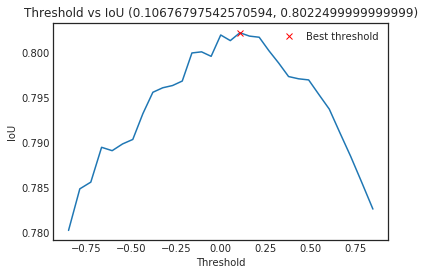

In [72]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [79]:
res_unet_noactiv.eval()
output_list = []
with torch.no_grad():
    for i, inputs in enumerate(test_loader):
        inputs_1 = torch.FloatTensor(inputs)
        inputs_2 = torch.flip(inputs_1, [3])
        inputs_1, inputs_2 = inputs_1.cuda(), inputs_2.cuda()
        outputs_1 = res_unet_noactiv(inputs_1)
        outputs_2 = res_unet_noactiv(inputs_2)
        outputs_2 = torch.flip(outputs_2, [3])
        outputs = 0.5 * (outputs_1 + outputs_2)
        output_list += [get_numpy(outputs)]
        if i % report_each == 0:
            print('iteration: [{0}/{1}]'.format(i, len(test_loader)))
output_test = np.concatenate(output_list, 0)

iteration: [0/282]
iteration: [10/282]
iteration: [20/282]
iteration: [30/282]
iteration: [40/282]
iteration: [50/282]
iteration: [60/282]
iteration: [70/282]
iteration: [80/282]
iteration: [90/282]
iteration: [100/282]
iteration: [110/282]
iteration: [120/282]
iteration: [130/282]
iteration: [140/282]
iteration: [150/282]
iteration: [160/282]
iteration: [170/282]
iteration: [180/282]
iteration: [190/282]
iteration: [200/282]
iteration: [210/282]
iteration: [220/282]
iteration: [230/282]
iteration: [240/282]
iteration: [250/282]
iteration: [260/282]
iteration: [270/282]
iteration: [280/282]


In [77]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [74]:
test_df = dl.get_test_df()

In [80]:
pred_dict = {idx: rle_encode(output_test[i] > threshold_best) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}